### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import display
import json
import numpy as np
import pandas as pd
import os
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tensorflow as tf

### Read scored test data

In [2]:
standard_data_path = 'gs://conversationai-models/biosbias/scored_data/standard_test.csv'
scrubbed_data_path = 'gs://conversationai-models/biosbias/scored_data/scrubbed_test.csv'

perf_df = pd.read_csv(tf.gfile.Open(standard_data_path)).drop_duplicates(subset=['tokens'])
scrubbed_df = pd.read_csv(tf.gfile.Open(scrubbed_data_path)).drop_duplicates(subset=['tokens'])

In [3]:
print(perf_df.shape)
print(scrubbed_df.shape)

(19829, 201)
(19828, 69)


In [4]:
df = perf_df.join(scrubbed_df, rsuffix = '_scrubbed')

In [5]:
df.head()

,tokens,gender,label,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_0,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_1,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_2,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_3,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_4,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_5,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247_6,...,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_23,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_24,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_25,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_26,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_27,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_28,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_29,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_30,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_31,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954_32
0,"[u'in', u'his', u'career', u'he', u'has', u're...",M,3,0.000030,1.481644e-16,0.000003,0.999415,6.231773e-08,1.657187e-08,5.000493e-10,...,0.000237,1.022816e-06,0.000110,0.001456,9.247497e-09,2.519182e-16,0.000015,3.130671e-04,0.000080,4.128487e-08
1,"[u'like', u'keats', u',', u'she', u'seeks', u'...",F,24,0.000358,5.320205e-12,0.003868,0.005619,1.016141e-06,1.004333e-04,1.406151e-04,...,0.002092,8.205463e-01,0.005582,0.008591,4.002794e-04,1.151956e-12,0.002781,5.614875e-04,0.040721,1.458319e-04
2,"[u'with', u'a', u'degree', u'in', u'both', u'f...",F,10,0.000122,2.086429e-14,0.000262,0.000889,1.753830e-07,4.022829e-03,1.572652e-03,...,0.000025,3.176962e-04,0.002818,0.000234,1.174002e-05,9.342651e-15,0.000654,1.156893e-05,0.002540,1.259932e-05
3,"[u'he', u'has', u'been', u'considered', u'as',...",M,18,0.000187,1.589816e-11,0.014234,0.003778,9.938718e-06,1.228533e-03,2.325906e-02,...,0.002938,5.874482e-03,0.054547,0.003046,3.182003e-03,1.945734e-11,0.000654,2.747838e-03,0.035171,9.126107e-05
4,"[u'his', u'research', u'interests', u'include'...",M,25,0.000003,9.075201e-14,0.000627,0.000022,2.752427e-08,2.030256e-08,1.343099e-06,...,0.000022,9.040638e-07,0.996070,0.000824,2.524824e-11,1.079238e-14,0.000436,9.989949e-07,0.000881,1.911942e-08


In [6]:
df.shape

(19829, 270)

In [7]:
df = df.dropna()
print(df.shape)

(19828, 270)


### Preprocessing

In [8]:
def get_class_from_col_name(col_name):
    #print(col_name)
    pattern = r'^.*_(\d+)$'
    return int(re.search(pattern, col_name).group(1))

In [9]:
def find_best_class(df, model_name, class_names):
    model_class_names = ['{}_{}'.format(model_name, class_name) for class_name in class_names]
    sub_df = df[model_class_names]
    df['{}_class'.format(model_name)] = sub_df.idxmax(axis=1).apply(get_class_from_col_name)

In [10]:
MODEL_NAMES = {
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113247': 'debiased_tuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113241': 'debiased_untuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113114': 'glove_tuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113106': 'glove_untuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_163707': 'strong_tuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_163723': 'strong_untuned',
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_113045': 'scrubbed_tuned', 
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190315_112954': 'scrubbed_untuned',
}

In [11]:
CLASS_NAMES = range(33)

In [12]:
for _model in MODEL_NAMES:
    find_best_class(df, _model, CLASS_NAMES)

In [13]:
# Labels with either gender having too few examples
bad_labels = df.groupby('label').gender.value_counts().reset_index(name = 'count').query('count < 5').label.values
assert len(bad_labels) == 0

### Accuracy Calculation

In [14]:
accuracy_list = []
for _model in MODEL_NAMES:
    is_correct = (df['{}_class'.format(_model)] == df['label'])
    _acc = sum(is_correct)/len(is_correct)
    accuracy_list.append(_acc)
    print ('Accuracy for model {}: {}'.format(MODEL_NAMES[_model], _acc))

Accuracy for model debiased_tuned: 0.815715150293
Accuracy for model debiased_untuned: 0.814807343151
Accuracy for model strong_tuned: 0.819144643938
Accuracy for model glove_tuned: 0.82045592092
Accuracy for model strong_untuned: 0.813596933629
Accuracy for model glove_untuned: 0.816169053863
Accuracy for model scrubbed_tuned: 0.819144643938
Accuracy for model scrubbed_untuned: 0.800534597539


### Fairness Metrics

In [15]:
for _class in CLASS_NAMES:
    df['label_{}'.format(_class)] = (df['label'] == _class)

In [16]:
# Gender ratios of classes
gender_counts = df.groupby('label').gender.value_counts().reset_index(name = 'count')

In [17]:
def frac_female(df):
    m_count = df[df['gender'] == "M"]['count'].values[0]
    f_count = df[df['gender'] == "F"]['count'].values[0]
    return {'label': df['label'].values[0], 'frac_female': f_count/(m_count+f_count)}

In [18]:
frac_female_df = pd.DataFrame(list(gender_counts.groupby('label', as_index = False).apply(frac_female)))

In [19]:
def compute_tpr(df, _class, _model, threshold = 0.5):
    tpr = metrics.recall_score(df['label_{}'.format(_class)],
                               df['{}_{}'.format(_model,_class)] > threshold)
    return tpr
    
def compute_tpr_by_gender(df, _class, _model, threshold = 0.5):
    tpr_m = compute_tpr(df.query('gender == "M"'), _class, _model, threshold)
    tpr_f = compute_tpr(df.query('gender == "F"'), _class, _model, threshold)
    return {'M': tpr_m, 'F': tpr_f}

In [20]:
def compute_tpr_tnr(df, _class, _model, threshold = 0.5):
    #cm = metrics.confusion_matrix(df['label_{}'.format(_class)],
    #                              df['{}_{}'.format(_model,_class)] > threshold)
    cm = pd.crosstab(df['label_{}'.format(_class)], df['{}_{}'.format(_model,_class)] > threshold)
    #display(cm)
    if cm.shape[0] > 1:
        tn = cm.iloc[0,0]
        fp = cm.iloc[0,1]
        fn = cm.iloc[1,0]
        tp = cm.iloc[1,1]
        tpr = tp/(tp+fn)
        tnr = tn/(tn+fp)
    else:
        tpr = 0
        tnr = 1
    return tpr, tnr

def compute_tr_by_gender(df, _class, _model, threshold = 0.5):
    tpr_m, tnr_m = compute_tpr_tnr(df.query('gender == "M"'), _class, _model, threshold)
    tpr_f, tnr_f = compute_tpr_tnr(df.query('gender == "F"'), _class, _model, threshold)
    return {'TPR_m': tpr_m, 'TPR_f': tpr_f, 'TNR_m': tnr_m, 'TNR_f': tnr_f}

In [21]:
for _class in CLASS_NAMES:
    for _model in MODEL_NAMES:
        tpr_1 = compute_tpr(df, _class, _model)
        tpr_2, _ = compute_tpr_tnr(df, _class, _model)
        assert tpr_1 == tpr_2, '{} != {}'.format(tpr_1, tpr_2)
        #print('{} == {}'.format(tpr_1, tpr_2))

In [22]:
tpr_df = pd.DataFrame()
for _class in frac_female_df.label:
    row = {}
    row['label'] = _class
    for _model, _model_type in MODEL_NAMES.items():
        tpr, tnr = compute_tpr_tnr(df, _class, _model)
        row['{}_tpr'.format(_model_type)] = tpr
        row['{}_tnr'.format(_model_type)] = tnr
        gender_trs = compute_tr_by_gender(df, _class, _model)
        row['{}_tpr_F'.format(_model_type)] = gender_trs['TPR_f']
        row['{}_tpr_M'.format(_model_type)] = gender_trs['TPR_m']
        row['{}_tpr_gender_gap'.format(_model_type)] = gender_trs['TPR_f'] - gender_trs['TPR_m']
        row['{}_tnr_F'.format(_model_type)] = gender_trs['TNR_f']
        row['{}_tnr_M'.format(_model_type)] = gender_trs['TNR_m']
        row['{}_tnr_gender_gap'.format(_model_type)] = gender_trs['TNR_f'] - gender_trs['TNR_m']
    tpr_df = tpr_df.append(row, ignore_index = True)

In [23]:
results_df = pd.merge(tpr_df, frac_female_df, on = 'label')

In [24]:
TITLE_LABELS = [
    'accountant', 'acupuncturist', 'architect', 'attorney', 'chiropractor', 'comedian', 'composer', 'dentist',
    'dietitian', 'dj', 'filmmaker', 'interior_designer', 'journalist', 'landscape_architect', 'magician',
    'massage_therapist', 'model', 'nurse', 'painter', 'paralegal', 'pastor', 'personal_trainer',
    'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper',
    'real_estate_broker', 'software_engineer', 'surgeon', 'teacher', 'yoga_teacher']

In [25]:
results_df['label_profession'] = results_df['label'].apply(lambda x: TITLE_LABELS[int(x)])

In [26]:
results_df[['frac_female']+['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]].corr()[['frac_female']]
    

,frac_female
frac_female,1.000000
debiased_tuned_tpr_gender_gap,0.442007
debiased_untuned_tpr_gender_gap,0.738924
strong_tuned_tpr_gender_gap,0.645211
glove_tuned_tpr_gender_gap,0.711791
strong_untuned_tpr_gender_gap,0.627283
glove_untuned_tpr_gender_gap,0.647357
scrubbed_tuned_tpr_gender_gap,0.341492
scrubbed_untuned_tpr_gender_gap,0.520765


In [27]:
tpr_gender_gap_cols = ['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]
tnr_gender_gap_cols = ['{}_tnr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]

In [28]:
gender_gap_df = results_df[['label_profession', 'frac_female']+tpr_gender_gap_cols+tnr_gender_gap_cols]
#gender_gap_df.columns = ['label_profession', 'frac_female']+['{}'.format(_model) for _model in MODEL_NAMES.values()]

In [29]:
gender_gap_df.sort_values('frac_female', ascending = False)

,label_profession,frac_female,debiased_tuned_tpr_gender_gap,debiased_untuned_tpr_gender_gap,strong_tuned_tpr_gender_gap,glove_tuned_tpr_gender_gap,strong_untuned_tpr_gender_gap,glove_untuned_tpr_gender_gap,scrubbed_tuned_tpr_gender_gap,scrubbed_untuned_tpr_gender_gap,debiased_tuned_tnr_gender_gap,debiased_untuned_tnr_gender_gap,strong_tuned_tnr_gender_gap,glove_tuned_tnr_gender_gap,strong_untuned_tnr_gender_gap,glove_untuned_tnr_gender_gap,scrubbed_tuned_tnr_gender_gap,scrubbed_untuned_tnr_gender_gap
13,nurse,0.913333,0.103781,0.094142,0.103406,0.065413,0.026483,0.074677,0.033034,0.056990,-0.013451,-0.009189,-0.006368,-0.009822,-0.004472,-0.008299,-0.008484,-0.007496
7,dietitian,0.900000,0.015873,0.259259,0.052910,0.116402,0.164021,0.174603,0.079365,0.074074,-0.002258,-0.001876,-0.001783,-0.001969,-0.001855,-0.002917,-0.001989,-0.001423
27,yoga_teacher,0.896552,0.017094,-0.021368,-0.008547,0.188034,0.012821,-0.047009,0.089744,-0.021368,-0.001124,-0.001105,-0.001012,-0.001012,-0.000900,-0.001217,-0.001441,-0.000808
15,paralegal,0.857143,0.393939,0.454545,0.242424,0.227273,0.287879,0.409091,0.318182,0.242424,-0.000208,-0.001735,-0.000004,0.000185,0.000054,-0.000748,0.000073,-0.000170
12,model,0.819407,0.555725,0.568883,0.563826,0.558769,0.529409,0.585330,0.492488,0.532944,-0.000361,-0.001767,-0.000536,-0.001274,0.001565,-0.000913,-0.000300,0.000077
10,interior_designer,0.742424,0.096038,0.295318,0.180072,0.060024,0.200480,0.141657,0.080432,0.100840,0.000166,-0.000577,-0.000207,0.000055,-0.000002,-0.000988,0.000313,0.000090
22,psychologist,0.615632,-0.003880,0.014645,0.001366,-0.067831,-0.011883,-0.019193,-0.024338,0.019479,-0.005905,-0.004092,-0.004249,-0.001270,-0.006115,-0.005507,-0.002363,-0.004891
26,teacher,0.591990,0.144606,0.177934,0.196176,0.200904,0.122057,0.162972,0.164425,0.122142,-0.002170,-0.002134,-0.002453,-0.004788,-0.000893,-0.002372,-0.003146,-0.000795
17,personal_trainer,0.583333,-0.028571,-0.007143,0.042857,0.078571,0.014286,-0.121429,0.064286,-0.021429,-0.000298,0.000296,-0.000205,-0.000242,-0.000520,-0.000354,-0.000854,-0.000316
11,journalist,0.489489,-0.008312,0.053362,0.009611,0.062468,0.033670,0.074991,-0.001792,0.036690,0.004109,-0.000966,0.001937,-0.000169,0.001959,-0.000280,0.003475,0.000804


In [30]:
# Fraction of comments where new model has lower
# TPR gap than the baseline

def compute_fraction_improved(df, baseline_model, improved_model):
    is_improved = np.abs(df[baseline_model]) >= np.abs(df[improved_model])
    return np.mean(is_improved)

In [31]:
for _model in MODEL_NAMES.values():
    print(_model)
    print(compute_fraction_improved(gender_gap_df, 'glove_untuned_tpr_gender_gap', '{}_tpr_gender_gap'.format(_model)))

debiased_tuned
0.6071428571428571
debiased_untuned
0.42857142857142855
strong_tuned
0.6071428571428571
glove_tuned
0.5714285714285714
strong_untuned
0.6071428571428571
glove_untuned
1.0
scrubbed_tuned
0.5714285714285714
scrubbed_untuned
0.6428571428571429


In [32]:
tpr_cols = ['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]
tnr_cols = ['{}_tnr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]
gender_gap_cols = tpr_cols + tnr_cols

In [33]:
gender_gap_df[gender_gap_cols].apply(lambda x: np.mean(x**2))

debiased_tuned_tpr_gender_gap      0.025907
debiased_untuned_tpr_gender_gap    0.035721
strong_tuned_tpr_gender_gap        0.033332
glove_tuned_tpr_gender_gap         0.024980
strong_untuned_tpr_gender_gap      0.021577
glove_untuned_tpr_gender_gap       0.029238
scrubbed_tuned_tpr_gender_gap      0.022480
scrubbed_untuned_tpr_gender_gap    0.020245
debiased_tuned_tnr_gender_gap      0.000014
debiased_untuned_tnr_gender_gap    0.000012
strong_tuned_tnr_gender_gap        0.000008
glove_tuned_tnr_gender_gap         0.000010
strong_untuned_tnr_gender_gap      0.000006
glove_untuned_tnr_gender_gap       0.000010
scrubbed_tuned_tnr_gender_gap      0.000008
scrubbed_untuned_tnr_gender_gap    0.000008
dtype: float64

In [34]:
gender_gap_df[gender_gap_cols].apply(lambda x: np.mean(np.abs(x)))

debiased_tuned_tpr_gender_gap      0.095339
debiased_untuned_tpr_gender_gap    0.120188
strong_tuned_tpr_gender_gap        0.106208
glove_tuned_tpr_gender_gap         0.104158
strong_untuned_tpr_gender_gap      0.088024
glove_untuned_tpr_gender_gap       0.107622
scrubbed_tuned_tpr_gender_gap      0.086712
scrubbed_untuned_tpr_gender_gap    0.086036
debiased_tuned_tnr_gender_gap      0.002205
debiased_untuned_tnr_gender_gap    0.002407
strong_tuned_tnr_gender_gap        0.001889
glove_tuned_tnr_gender_gap         0.001991
strong_untuned_tnr_gender_gap      0.001717
glove_untuned_tnr_gender_gap       0.002193
scrubbed_tuned_tnr_gender_gap      0.001832
scrubbed_untuned_tnr_gender_gap    0.001694
dtype: float64

In [35]:
def plot_tpr_gap(df, _model):
    fig, ax = plt.subplots(figsize=(15, 6))
    x = 'frac_female'
    y = '{}_tpr_gender_gap'.format(_model)
    p1 = sns.regplot(x = x, y = y, data = df)
    p1.set(xlabel = "% Female", ylabel = "TPR Gender Gap", title = _model)

    for line in range(0,df.shape[0]):
         p1.text(results_df[x][line]+0.01, df[y][line], df['label_profession'][line], horizontalalignment='left', size='medium', color='black')
    plt.show()

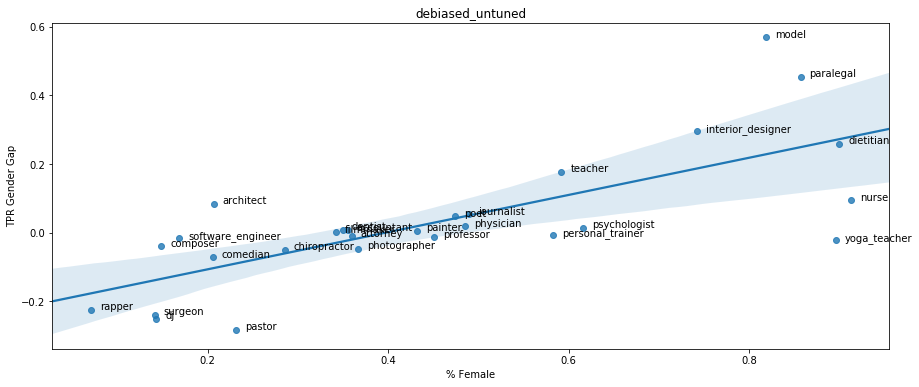

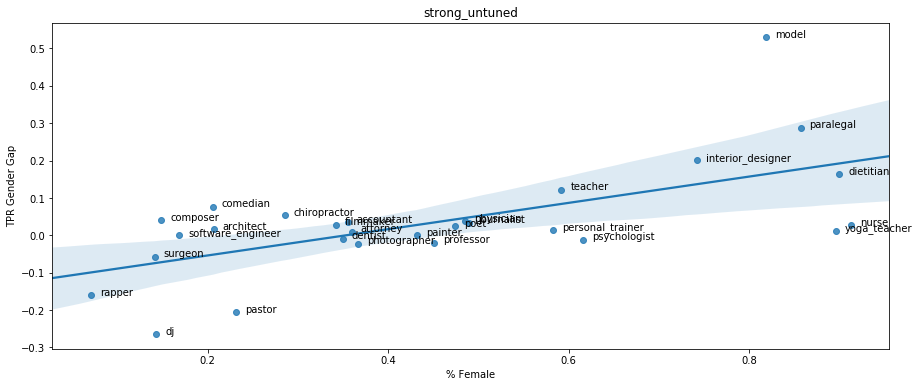

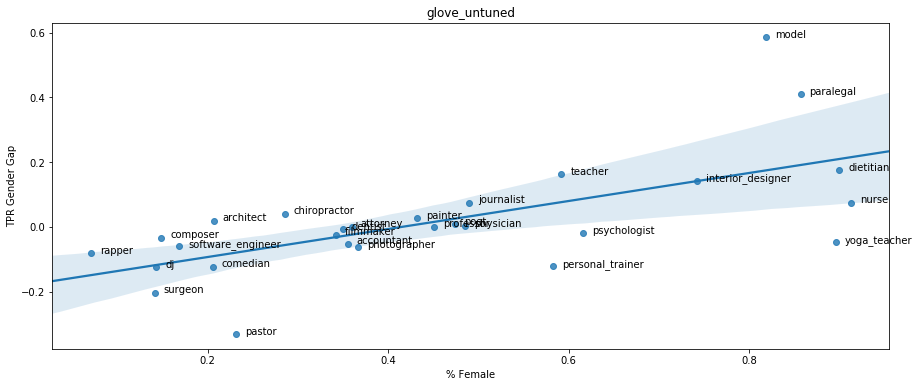

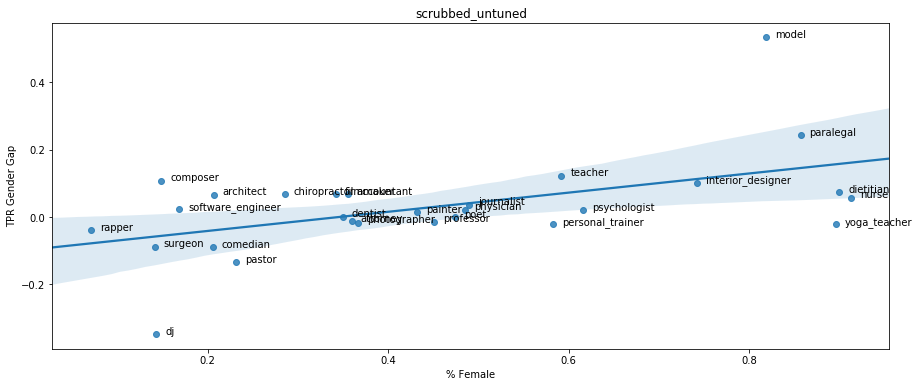

In [36]:
for _model in MODEL_NAMES.values():
    if 'untuned' in _model:
        plot_tpr_gap(results_df, _model)

In [37]:
results_df[['frac_female']+['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES.values()]].corr()[['frac_female']]

,frac_female
frac_female,1.000000
debiased_tuned_tpr_gender_gap,0.442007
debiased_untuned_tpr_gender_gap,0.738924
strong_tuned_tpr_gender_gap,0.645211
glove_tuned_tpr_gender_gap,0.711791
strong_untuned_tpr_gender_gap,0.627283
glove_untuned_tpr_gender_gap,0.647357
scrubbed_tuned_tpr_gender_gap,0.341492
scrubbed_untuned_tpr_gender_gap,0.520765
